### Aleksandra Jonas, Aleksandra Gronowska, Iwona Christop
# Zestaw 9-10/zadanie2 - AlexNet, VGG16, ResNet on village

### Przygotowanie danych

In [1]:
from IPython.display import Image, display

In [3]:
import sys
import subprocess
import pkg_resources
import numpy as np

required = { 'scikit-image'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing: 
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

def load_data(input_dir, img_size):
    import numpy as np
    import pandas as pd
    import os
    from skimage.io import imread
    import cv2 as cv
    from pathlib import Path
    import random
    from shutil import copyfile, rmtree
    import json

    import seaborn as sns
    import matplotlib.pyplot as plt

    import matplotlib
    
    image_dir = Path(input_dir)
    categories_name = []
    for file in os.listdir(image_dir):
        d = os.path.join(image_dir, file)
        if os.path.isdir(d):
            categories_name.append(file)

    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    
    ds_img = []
    categories_count=[]
    labels=[]
    for i, direc in enumerate(folders):
        count = 0
        for obj in direc.iterdir():
            if os.path.isfile(obj) and os.path.basename(os.path.normpath(obj)) != 'desktop.ini':
                labels.append(os.path.basename(os.path.normpath(direc)))
                count += 1
                img = imread(obj)#zwraca ndarry postaci xSize x ySize x colorDepth
                img = img[:, :, :3]
                img = cv.resize(img, img_size, interpolation=cv.INTER_AREA)# zwraca ndarray
                img = img / 255 #normalizacja
                ds_img.append(img)
        categories_count.append(count)
    X={}
    X["values"] = np.array(ds_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

In [3]:
def get_run_logdir(root_logdir):
    import os
    import time

    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [4]:
def diagram_setup(model_name):
    from tensorflow import keras
    import os
    
    root_logdir = os.path.join(os.curdir, f"logs\\fit\\{model_name}\\")
    
    run_logdir = get_run_logdir(root_logdir)
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [2]:
def prepare_data(path, img_size, test_size, val_size):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder
    import tensorflow as tf

    data = load_data(path, img_size)
    values = data['values']
    labels = data['labels']

    X_train, X_test, y_train, y_test = train_test_split(values, labels, test_size=test_size, random_state=42)
    X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=val_size, random_state=42)

    class_le = LabelEncoder()
    y_train_enc = class_le.fit_transform(y_train)
    y_validate_enc = class_le.fit_transform(y_validate)
    y_test_enc = class_le.fit_transform(y_test)

    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_enc))
    validation_ds = tf.data.Dataset.from_tensor_slices((X_validate, y_validate_enc))
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))

    train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
    test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
    validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()

    #Rozmiary zbiorów
    print("Training:", train_ds_size)
    print("Test:", test_ds_size)
    print("Validation:", validation_ds_size)

    # Mieszanie zriorów
    train_ds = (train_ds.shuffle(buffer_size=train_ds_size).batch(batch_size=32, drop_remainder=True))
    test_ds = (test_ds.shuffle(buffer_size=train_ds_size).batch(batch_size=32, drop_remainder=True))
    validation_ds = (validation_ds.shuffle(buffer_size=train_ds_size).batch(batch_size=32, drop_remainder=True))

    return train_ds, test_ds, validation_ds



# AlexNet

In [6]:
from tensorflow import keras
import tensorflow as tf
import os
import time

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(12, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 384)       1

In [7]:
train_ds_a, test_ds_a, val_ds_a = prepare_data("./plantvillage/color", (227, 227), 0.2, 0.2)

Training: 7430
Test: 2323
Validation: 1858


In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("alex_2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

alex = model.fit_generator(
    steps_per_epoch=len(train_ds_a), 
    generator=train_ds_a, 
    validation_data= val_ds_a, 
    validation_steps=len(val_ds_a), 
    epochs=25, 
    callbacks=[checkpoint,early])

/var/folders/_h/ljwht4gd7lb99rm1hm78h7_00000gn/T/ipykernel_23432/2397086753.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  alex = model.fit_generator(


Epoch 1/25


2023-01-06 20:01:38.622228: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


232/232 [==============================] - ETA: 0s - loss: 2.1314 - accuracy: 0.2501
Epoch 1: val_accuracy improved from -inf to 0.44235, saving model to alex_2.h5
232/232 [==============================] - 223s 956ms/step - loss: 2.1314 - accuracy: 0.2501 - val_loss: 1.6157 - val_accuracy: 0.4423
Epoch 2/25
232/232 [==============================] - ETA: 0s - loss: 1.3779 - accuracy: 0.5031
Epoch 2: val_accuracy improved from 0.44235 to 0.60614, saving model to alex_2.h5
232/232 [==============================] - 264s 1s/step - loss: 1.3779 - accuracy: 0.5031 - val_loss: 1.1473 - val_accuracy: 0.6061
Epoch 3/25
232/232 [==============================] - ETA: 0s - loss: 1.0262 - accuracy: 0.6358
Epoch 3: val_accuracy improved from 0.60614 to 0.67726, saving model to alex_2.h5
232/232 [==============================] - 266s 1s/step - loss: 1.0262 - accuracy: 0.6358 - val_loss: 0.9024 - val_accuracy: 0.6773
Epoch 4/25
232/232 [==============================] - ETA: 0s - loss: 0.7844 - ac

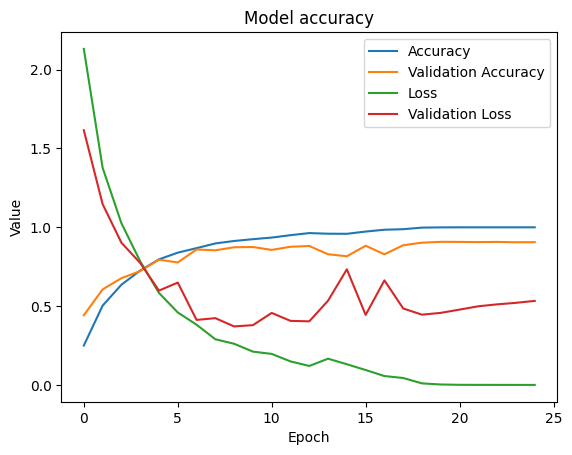

In [9]:
import matplotlib.pyplot as plt
plt.plot(alex.history["accuracy"])
plt.plot(alex.history['val_accuracy'])
plt.plot(alex.history['loss'])
plt.plot(alex.history['val_loss'])
plt.title("Model accuracy")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

In [10]:
model.evaluate(test_ds_a)

72/72 [==============================] - 23s 318ms/step - loss: 0.4541 - accuracy: 0.9084


[0.45413827896118164, 0.9084201455116272]

# VGG16

In [10]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import numpy as np

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(224,224,3), padding="same"),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(224,224,3), padding="same"),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 4096, activation='relu'),
    keras.layers.Dense(units = 4096, activation='relu'),
    keras.layers.Dense(units = 12, activation='softmax')
])

opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

/opt/homebrew/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
train_ds_v, test_ds_v, val_ds_v = prepare_data('./plantvillage/color', (224, 224), 0.2, 0.2)

Training: 7430
Test: 2323
Validation: 1858


In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg16_2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
vgg = model.fit_generator(steps_per_epoch=len(train_ds_v), generator=train_ds_v, validation_data= val_ds_v, validation_steps=len(val_ds_v), epochs=25, callbacks=[checkpoint,early])

/var/folders/_h/ljwht4gd7lb99rm1hm78h7_00000gn/T/ipykernel_24066/3966396738.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg = model.fit_generator(steps_per_epoch=len(train_ds_v), generator=train_ds_v, validation_data= val_ds_v, validation_steps=len(val_ds_v), epochs=25, callbacks=[checkpoint,early])


Epoch 1/25


2023-01-06 22:32:18.362109: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


232/232 [==============================] - ETA: 0s - loss: 2.4227 - accuracy: 0.1339 
Epoch 1: val_accuracy improved from -inf to 0.15086, saving model to vgg16_2.h5
232/232 [==============================] - 3659s 16s/step - loss: 2.4227 - accuracy: 0.1339 - val_loss: 2.4052 - val_accuracy: 0.1509
Epoch 2/25
232/232 [==============================] - ETA: 0s - loss: 2.4051 - accuracy: 0.1356 
Epoch 2: val_accuracy did not improve from 0.15086
232/232 [==============================] - 3761s 16s/step - loss: 2.4051 - accuracy: 0.1356 - val_loss: 2.4036 - val_accuracy: 0.1509
Epoch 3/25
232/232 [==============================] - ETA: 0s - loss: 2.4026 - accuracy: 0.1381 
Epoch 3: val_accuracy did not improve from 0.15086
232/232 [==============================] - 3712s 16s/step - loss: 2.4026 - accuracy: 0.1381 - val_loss: 2.4002 - val_accuracy: 0.1503
Epoch 4/25
232/232 [==============================] - ETA: 0s - loss: 2.4015 - accuracy: 0.1379 
Epoch 4: val_accuracy did not improve f

In [11]:
import matplotlib.pyplot as plt
plt.plot(vgg.history["accuracy"])
plt.plot(vgg.history['val_accuracy'])
plt.plot(vgg.history['loss'])
plt.plot(vgg.history['val_loss'])
plt.title("Model accuracy")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

NameError: name 'vgg' is not defined

In [5]:
model.evaluate(test_ds_v)

NameError: name 'model' is not defined

# ResNet50

In [9]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# re-size all the images to this
IMAGE_SIZE = [224, 224]

# add preprocessing layer to the front of resnet
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in resnet.layers:
  layer.trainable = False
  
  # useful for getting number of classes
classes = 12
  

# our layers - you can add more if you want
x = Flatten()(resnet.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(12, activation='softmax')(x)

# create a model object
model_resnet = Model(inputs=resnet.input, outputs=prediction)

# view the structure of the model
model_resnet.summary()

# tell the model what cost and optimization method to use
model_resnet.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [6]:
train_ds_r, test_ds_r, val_ds_r = prepare_data('./plantvillage/color', img_size=IMAGE_SIZE, test_size=0.2, val_size=0.2)

Training: 7430
Test: 2323
Validation: 1858


In [16]:
r = model_resnet.fit_generator(
  train_ds_r,
  validation_data=val_ds_r,
  epochs=25,
  steps_per_epoch=len(train_ds_r),
  validation_steps=len(val_ds_r)
)

Epoch 1/25


/var/folders/_h/ljwht4gd7lb99rm1hm78h7_00000gn/T/ipykernel_39241/1735889553.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model_resnet.fit_generator(


232/232 [==============================] - 297s 1s/step - loss: 0.6232 - accuracy: 0.8380 - val_loss: 1.2547 - val_accuracy: 0.7328
Epoch 2/25
232/232 [==============================] - 277s 1s/step - loss: 0.4919 - accuracy: 0.8611 - val_loss: 0.8189 - val_accuracy: 0.8308
Epoch 3/25
232/232 [==============================] - 299s 1s/step - loss: 0.6947 - accuracy: 0.8382 - val_loss: 0.5326 - val_accuracy: 0.8518
Epoch 4/25
232/232 [==============================] - 306s 1s/step - loss: 0.6153 - accuracy: 0.8599 - val_loss: 1.1360 - val_accuracy: 0.7710
Epoch 5/25
232/232 [==============================] - 311s 1s/step - loss: 0.5149 - accuracy: 0.8689 - val_loss: 1.3260 - val_accuracy: 0.7780
Epoch 6/25
232/232 [==============================] - 313s 1s/step - loss: 0.6220 - accuracy: 0.8462 - val_loss: 0.8199 - val_accuracy: 0.8233
Epoch 7/25
232/232 [==============================] - 318s 1s/step - loss: 0.6513 - accuracy: 0.8412 - val_loss: 1.1632 - val_accuracy: 0.7457
Epoch 8/25

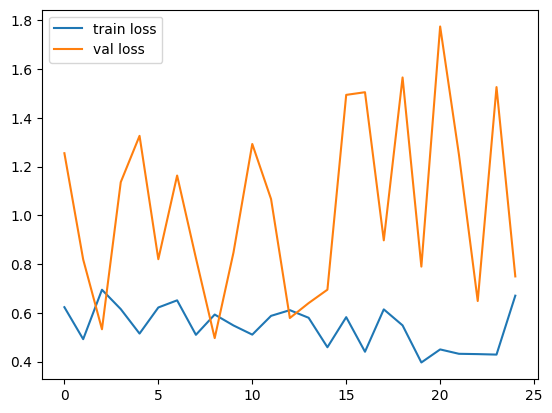

<Figure size 640x480 with 0 Axes>

In [17]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')



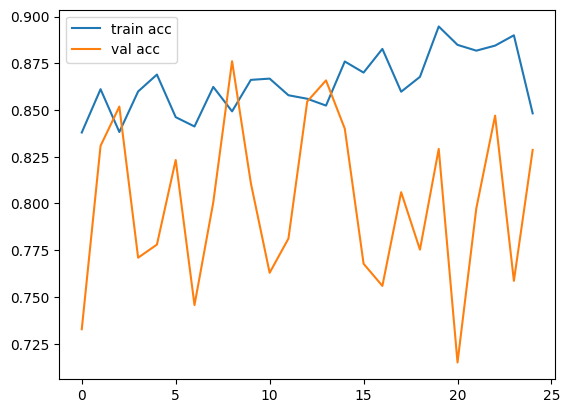

<Figure size 640x480 with 0 Axes>

In [21]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')



In [20]:
model_resnet.save('resnet_new_model_2.h5')

In [23]:
model_resnet.evaluate(test_ds_r)

72/72 [==============================] - 61s 843ms/step - loss: 0.7182 - accuracy: 0.8411


[0.7181549072265625, 0.8411458134651184]